<a href="https://colab.research.google.com/github/toastmaker/ccf/blob/master/notebooks/ccf_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
from google.colab import files
import numpy as np
import matplotlib.pyplot  as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
copypath = '/content/drive/My Drive/data/lightcurve_array.npz'
npz=np.load(copypath)
xdata=npz['lc']
ydata=npz['delay']

In [100]:
xdata=xdata/np.max(xdata,axis=1)[:,np.newaxis]

In [101]:
xdata.shape

(9999, 9999)

Delay is 0.050


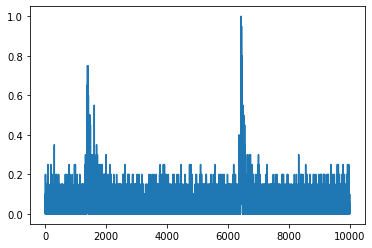

In [102]:
lc_preview = xdata[0]
plt.plot(lc_preview)
print("Delay is {:.3f}".format(ydata[0]))

In [103]:
def ccf(x):
  half = len(x)//2
  return np.correlate(x[0:half],x[half:],'full')   

In [104]:
# !pip install -q keras

(9998,)

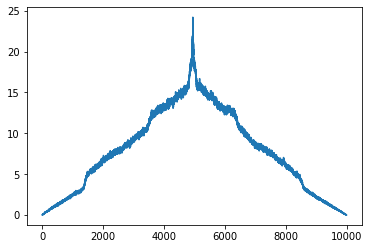

In [105]:
ccf_res =  ccf(xdata[0])
plt.plot(ccf_res)
ccf_res.shape

In [106]:
ccfdata = np.apply_along_axis(func1d=ccf, axis=1, arr=xdata)

In [107]:
ccfdata.shape

(9999, 9998)

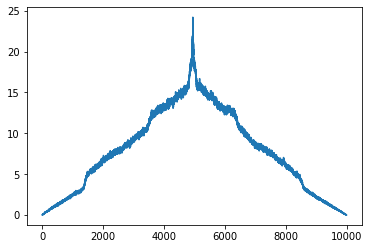

In [108]:
ccfdata_preview =  ccfdata[0]
plt.plot(ccfdata_preview)

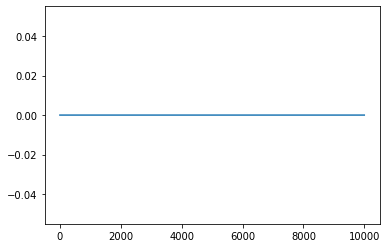

In [109]:
# sanity check
plt.plot(ccfdata_preview-ccf_res)

1.8474111129762604e-16 1.0


(9999, 2000)

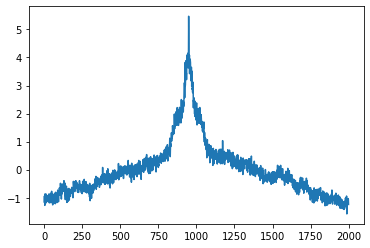

In [110]:
nbins_full = ccfdata.shape[1]
xtrain = ccfdata[:,nbins_full//2-1000:nbins_full//2+1000]
#z = (x - u) / s
xtrain = (xtrain - np.mean(xtrain, axis=1)[:,None])/np.std(xtrain,axis=1)[:,None]
plt.plot(xtrain[0])
print(np.mean(xtrain[0]), np.std(xtrain[0]))
xtrain.shape


In [38]:
ntrain = 6000
nvalid = 3000
X = xtrain[:ntrain]
X_validation = xtrain[ntrain:ntrain+nvalid]
y = ydata[:ntrain]
y_validation = ydata[ntrain:ntrain+nvalid]
orig_dim=X[0].shape
X.shape, y.shape

((6000, 2000), (6000,))

In [39]:
model = Sequential()
model.add(Dense(units=48, input_shape=(orig_dim),activation='sigmoid'))
model.add(Dense(units=24,activation='sigmoid'))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='sgd')

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 48)                96048     
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 97,249
Trainable params: 97,249
Non-trainable params: 0
_________________________________________________________________


In [41]:
nepochs = 200
history = model.fit(X,y,epochs=nepochs,batch_size=100, validation_data=(X_validation,y_validation))

Epoch 1/200
60/60 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 5.0536e-04
Epoch 2/200
60/60 [==============================] - 0s 4ms/step - loss: 4.1529e-04 - val_loss: 3.3776e-04
Epoch 3/200
60/60 [==============================] - 0s 4ms/step - loss: 3.0656e-04 - val_loss: 2.7829e-04
Epoch 4/200
60/60 [==============================] - 0s 4ms/step - loss: 2.6809e-04 - val_loss: 2.5608e-04
Epoch 5/200
60/60 [==============================] - 0s 4ms/step - loss: 2.5344e-04 - val_loss: 2.4698e-04
Epoch 6/200
60/60 [==============================] - 0s 4ms/step - loss: 2.4637e-04 - val_loss: 2.4340e-04
Epoch 7/200
60/60 [==============================] - 0s 4ms/step - loss: 2.4307e-04 - val_loss: 2.3929e-04
Epoch 8/200
60/60 [==============================] - 0s 4ms/step - loss: 2.4019e-04 - val_loss: 2.3672e-04
Epoch 9/200
60/60 [==============================] - 0s 4ms/step - loss: 2.3751e-04 - val_loss: 2.3449e-04
Epoch 10/200
60/60 [=====================

In [42]:
model.save('/content/drive/My Drive/data/my_ccfmodel')

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/my_ccfmodel/assets


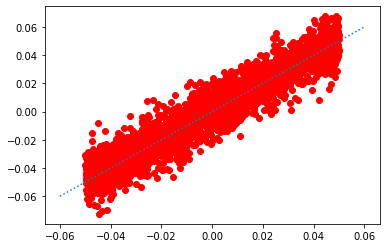

In [43]:
ypred = model.predict(X_validation)
plt.scatter(y_validation,ypred,color="r")
plt.plot([-0.06,0.06],[-0.06,0.06],':')

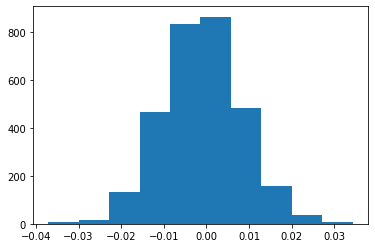

In [44]:
diff = y_validation - ypred.ravel()
hist = plt.hist(diff)

In [45]:
bincentres = (hist[1][:-1]+hist[1][1:])/2.
weights = hist[0]
mu = np.average(bincentres,weights=weights)
sigma = np.average((bincentres-mu)**2, weights=weights)

In [46]:
mu, sigma

(-0.0009572201776062162, 9.039538157945052e-05)

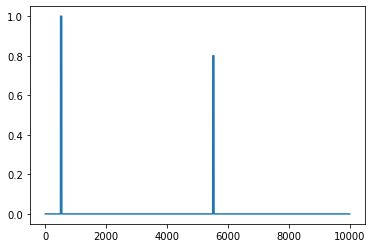

In [123]:
# toy model
lc_test = np.zeros(9999)
p1 = 500
delay, width = 0,40
p2 = p1 + 5000 + delay
lc_test[p1:p1+width]=1.
lc_test[p2:p2+width]=0.8
plt.plot(lc_test)

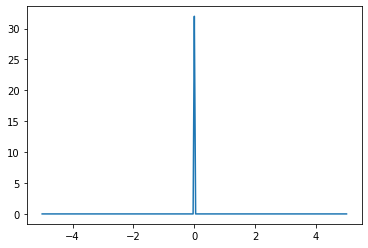

In [125]:
ccf_test = ccf(lc_test)
dt = 1e-3
t = dt*np.linspace( -len(lc_test)//2, len(lc_test)//2,len(lc_test)-1)
plt.plot(t,ccf_test)
#np.mean(ccf_test)

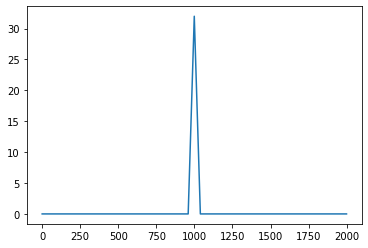

In [126]:
ccf_test_cut = ccf_test[nbins_full//2-1000:nbins_full//2+1000]
plt.plot(ccf_test_cut)

In [127]:
X_test = ccf_test_cut[np.newaxis,:]
X_test.shape
y_test_pred = model.predict(X_test)

In [130]:
y_test_pred

array([[0.06893236]], dtype=float32)

In [142]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [144]:
pca = PCA(n_components=200)
X_train, X_test, y_train, y_test = train_test_split(xtrain, ydata, random_state=0)
X_train_pca = pca.fit_transform(X_train)

In [145]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train_pca, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

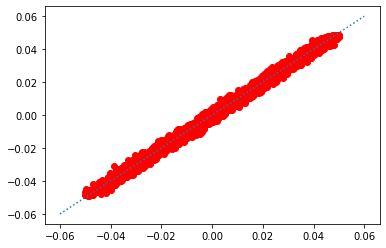

In [146]:
ypred = gbr.predict(pca.transform(X_test))
plt.scatter(y_test,ypred,color="r")
plt.plot([-0.06,0.06],[-0.06,0.06],':')

In [147]:
def howGoodAmI(ytest, ypred):
  diff = y_test - ypred
  hist = plt.hist(diff)
  bincentres = (hist[1][:-1]+hist[1][1:])/2.
  weights = hist[0]
  mu = np.average(bincentres,weights=weights)
  sigma = np.average((bincentres-mu)**2, weights=weights)
  return mu, sigma

(4.397463698345773e-05, 4.4510422626889576e-06)

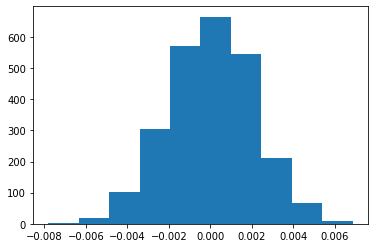

In [148]:
howGoodAmI(y_test, ypred)

In [74]:
ydata[10]

0.02599437981843948

In [77]:
gbr.predict(ccf_test_cut[None,:])

array([0.00617155])